# install data

In [ ]:
import os
import json
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [ ]:
# install Kaggle
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chaimabouab","key":"4c9dba2231ee394879b8af8eafc26cdc"}'}

In [ ]:
#Creat a kaggle folder
!mkdir ~/.kaggle

In [ ]:
#copy the kaggle.json to folder created
!cp kaggle.json  ~/.kaggle/

In [ ]:
#permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-dataset

100% 23.1G/23.1G [04:01<00:00, 193MB/s]
100% 23.1G/23.1G [04:01<00:00, 103MB/s]


In [ ]:
!unzip fashion-product-images-dataset.zip

# EDA

In [ ]:
!pip install keras-tuner
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.0/254.0 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00


In [ ]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import tensorflow as tf
# data generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# wandb
import wandb
from wandb.keras import WandbCallback

DATA_PATH = './fashion-dataset'

%matplotlib inline

In [ ]:
images_df = pd.read_csv(
    os.path.join(DATA_PATH, 'fashion-dataset', 'images.csv')
)

In [ ]:
images_df.head(2)

,filename,link
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...


In [ ]:
styles_df = pd.read_csv(
    os.path.join(DATA_PATH, 'fashion-dataset', 'styles.csv'),
    on_bad_lines='skip'
)

In [ ]:
styles_df.head(2)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans


In [ ]:
images_df.head(2)

,filename,link
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...


In [ ]:
images_df['id'] = images_df['filename']\
.apply(lambda filename: filename\
       .replace('.jpg', '')).astype(int)

In [ ]:
images_df.head(2)

,filename,link,id
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...,15970
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...,39386


In [ ]:
data = styles_df.merge(images_df, on='id', how='left')
data.head(2)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,link
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg,http://assets.myntassets.com/v1/images/style/p...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg,http://assets.myntassets.com/v1/images/style/p...


In [ ]:
# convert filename to filepath
data['filename'] = data['filename']\
.apply(lambda filename: os.path.join(DATA_PATH, 'fashion-dataset', 'images', filename))
data.head(2)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,link
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,./fashion-dataset/fashion-dataset/images/15970...,http://assets.myntassets.com/v1/images/style/p...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,./fashion-dataset/fashion-dataset/images/39386...,http://assets.myntassets.com/v1/images/style/p...


In [ ]:
# get list of images in dataset
image_files = os.listdir(
    os.path.join(DATA_PATH, 'fashion-dataset', 'images')
)
print(len(image_files))

44441


In [ ]:
# files included in the dataset
data['file_found'] = data['id'].apply(lambda idx: '{}.jpg'.format(idx)  in image_files)

In [ ]:
data['file_found'].value_counts()

True     44419
False        5
Name: file_found, dtype: int64

In [ ]:
# delete files without images in the dataset
data = data[data['file_found']].reset_index(drop=True)
print(data.shape)
data.head(2)

(44419, 13)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,link,file_found
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,./fashion-dataset/fashion-dataset/images/15970...,http://assets.myntassets.com/v1/images/style/p...,True
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,./fashion-dataset/fashion-dataset/images/39386...,http://assets.myntassets.com/v1/images/style/p...,True


In [ ]:
data.isnull().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
filename                0
link                    0
file_found              0
dtype: int64

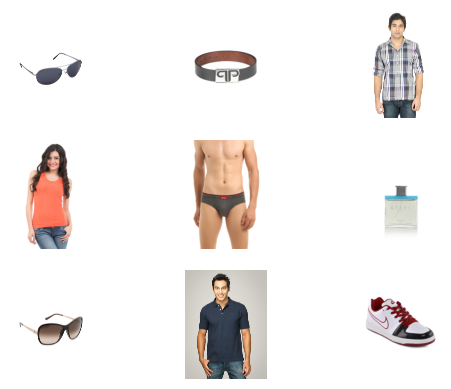

In [ ]:
# Visualize some images in datasets
def dislay_image(image_files):
    random.shuffle(image_files)
    for idx, image_file in enumerate(image_files[0:9]):
        plt.subplot(3, 3, idx+1)
        image_path = os.path.join(DATA_PATH, 'fashion-dataset', 'images', image_file)
        image_arr = cv2.imread(image_path)
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB)

        plt.imshow(image_arr)
        plt.axis("off")

dislay_image(image_files)

In [ ]:
# masterCategory count
gr_data_masterCate = data.groupby('masterCategory').size()
gr_data_masterCate_sorted= gr_data_masterCate.sort_values()
gr_data_masterCate_sorted

masterCategory
Home                  1
Sporting Goods       25
Free Items          105
Personal Care      2403
Footwear           9219
Accessories       11274
Apparel           21392
dtype: int64

In [ ]:
# subCategory count
gr_data_subCate = data.groupby('subCategory').size()
gr_data_subCate_sorted= gr_data_subCate.sort_values()

In [ ]:
len(gr_data_subCate_sorted)

45

In [ ]:
# articleType count
gr_data_articleType = data.groupby('articleType').size()
gr_data_articleType_sorted = gr_data_articleType.sort_values()

In [ ]:
categoricals = sorted(list(gr_data_subCate_sorted.index[-20:]))

In [ ]:
data_20 = data[data['subCategory'].isin(categoricals)]

In [ ]:
data_20 = data_20[['subCategory', 'filename']]

In [ ]:
data_20

,subCategory,filename
0,Topwear,./fashion-dataset/fashion-dataset/images/15970...
1,Bottomwear,./fashion-dataset/fashion-dataset/images/39386...
2,Watches,./fashion-dataset/fashion-dataset/images/59263...
3,Bottomwear,./fashion-dataset/fashion-dataset/images/21379...
4,Topwear,./fashion-dataset/fashion-dataset/images/53759...
...,...,...
44414,Shoes,./fashion-dataset/fashion-dataset/images/17036...
44415,Flip Flops,./fashion-dataset/fashion-dataset/images/6461.jpg
44416,Topwear,./fashion-dataset/fashion-dataset/images/18842...
44417,Fragrance,./fashion-dataset/fashion-dataset/images/46694...


In [ ]:
data_20.groupby('subCategory').size().sort_values(ascending=False)

subCategory
Topwear                     15398
Shoes                        7343
Bags                         3055
Bottomwear                   2693
Watches                      2542
Innerwear                    1808
Jewellery                    1079
Eyewear                      1073
Fragrance                    1011
Sandal                        963
Wallets                       933
Flip Flops                    913
Belts                         811
Socks                         698
Lips                          527
Dress                         478
Loungewear and Nightwear      470
Saree                         427
Nails                         329
Makeup                        307
dtype: int64

In [ ]:
from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split

In [ ]:
n_samples = 600
lst_df = []
for categorical in categoricals:
    df_class_tmp = data_20.loc[data_20['subCategory'] == categorical]
    if df_class_tmp.shape[0] < n_samples:
        df_resample_tmp = df_class_tmp
    else:
        df_resample_tmp = resample(df_class_tmp, n_samples=n_samples, random_state=42)
    lst_df.append(df_resample_tmp)
df = pd.concat(lst_df)

In [ ]:
df.shape

(10938, 2)

In [ ]:
df = shuffle(df, random_state=42)
df = df.reset_index(drop=True)

In [ ]:
df.rename({'subCategory':'categorical'}, axis=1, inplace=True)

In [ ]:
# final data
data = df
data

,categorical,filename
0,Bags,./fashion-dataset/fashion-dataset/images/4596.jpg
1,Makeup,./fashion-dataset/fashion-dataset/images/56581...
2,Lips,./fashion-dataset/fashion-dataset/images/55488...
3,Fragrance,./fashion-dataset/fashion-dataset/images/45693...
4,Dress,./fashion-dataset/fashion-dataset/images/57052...
...,...,...
10933,Lips,./fashion-dataset/fashion-dataset/images/55028...
10934,Jewellery,./fashion-dataset/fashion-dataset/images/52328...
10935,Lips,./fashion-dataset/fashion-dataset/images/55978...
10936,Belts,./fashion-dataset/fashion-dataset/images/25753...


# Splite data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_df, test_df = train_test_split(data,\
                                     test_size=0.2,\
                                     random_state=42,\
                                     stratify=data['categorical'])
valid_df, test_df = train_test_split(test_df,\
                                      test_size=0.5,\
                                      random_state=42,\
                                      stratify=test_df['categorical'])


In [ ]:
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


In [ ]:
train_df

,categorical,filename
0,Fragrance,./fashion-dataset/fashion-dataset/images/58959...
1,Belts,./fashion-dataset/fashion-dataset/images/12453...
2,Sandal,./fashion-dataset/fashion-dataset/images/7969.jpg
3,Bags,./fashion-dataset/fashion-dataset/images/53369...
4,Shoes,./fashion-dataset/fashion-dataset/images/4993.jpg
...,...,...
8745,Innerwear,./fashion-dataset/fashion-dataset/images/59080...
8746,Dress,./fashion-dataset/fashion-dataset/images/34578...
8747,Nails,./fashion-dataset/fashion-dataset/images/55868...
8748,Fragrance,./fashion-dataset/fashion-dataset/images/26733...


# Data augmentation

In [ ]:
datagen = ImageDataGenerator(rescale=1/255.,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True)

train_generator = datagen.flow_from_dataframe(dataframe=train_df,
                                             target_size=(224,224),
                                             x_col='filename',
                                            y_col='categorical',
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=True,
                                              seed=42)


test_datagen = ImageDataGenerator(rescale=1/255.)
valid_generator = test_datagen.flow_from_dataframe(dataframe=valid_df,
                                             target_size=(224,224),
                                             x_col='filename',
                                            y_col='categorical',
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=True,
                                              seed=42)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='categorical',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)


Found 8750 validated image filenames belonging to 20 classes.
Found 1094 validated image filenames belonging to 20 classes.
Found 1094 validated image filenames belonging to 20 classes.


# Build And Train the Model

# VGG16

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
def build_model_VGG16(name, weights_path=None):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(4096, activation='leaky_relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(1024, activation='sigmoid')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    predictions = Dense(20, activation='softmax')(x)

    model = Model(name=name, inputs=base_model.input, outputs=predictions)
    if weights_path:
        model.load_weights(weights_path)
    return model

In [ ]:
import time

In [ ]:
NAME = "vgg16-{}".format(int(time.time()))
model_VGG16 = build_model_VGG16(NAME)
model_VGG16.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16-1702402158"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                   

In [ ]:
lr = 0.01
epochs = 10


In [ ]:
model_VGG16.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr),
              metrics=['accuracy'])

In [ ]:
history_VGG16 = model_VGG16.fit_generator(train_generator,
                    validation_data = valid_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    epochs=epochs,
                    )

Epoch 1/10
273/273 [==============================] - 258s 893ms/step - loss: 1.7850 - accuracy: 0.6358 - val_loss: 0.7141 - val_accuracy: 0.8107
Epoch 2/10
273/273 [==============================] - 222s 812ms/step - loss: 0.9829 - accuracy: 0.7659 - val_loss: 0.7086 - val_accuracy: 0.8088
Epoch 3/10
273/273 [==============================] - 230s 840ms/step - loss: 0.7141 - accuracy: 0.8068 - val_loss: 0.3533 - val_accuracy: 0.8732
Epoch 4/10
273/273 [==============================] - 228s 835ms/step - loss: 0.5326 - accuracy: 0.8382 - val_loss: 0.4471 - val_accuracy: 0.8676
Epoch 5/10
273/273 [==============================] - 227s 833ms/step - loss: 0.4320 - accuracy: 0.8603 - val_loss: 0.3335 - val_accuracy: 0.9017
Epoch 6/10
273/273 [==============================] - 228s 834ms/step - loss: 0.4032 - accuracy: 0.8697 - val_loss: 0.2355 - val_accuracy: 0.9320
Epoch 7/10
273/273 [==============================] - 223s 817ms/step - loss: 0.3928 - accuracy: 0.8726 - val_loss: 0.3363 -

In [ ]:
model_VGG16.save('VGG16_model.h5')

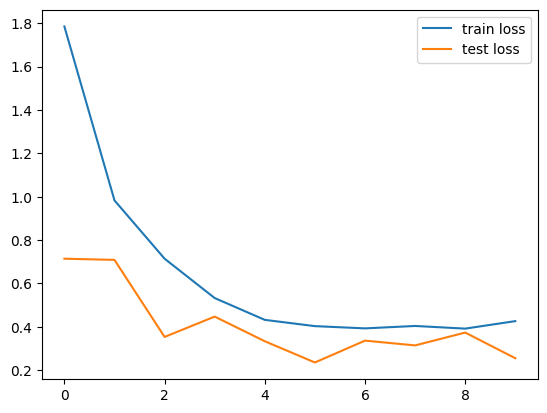

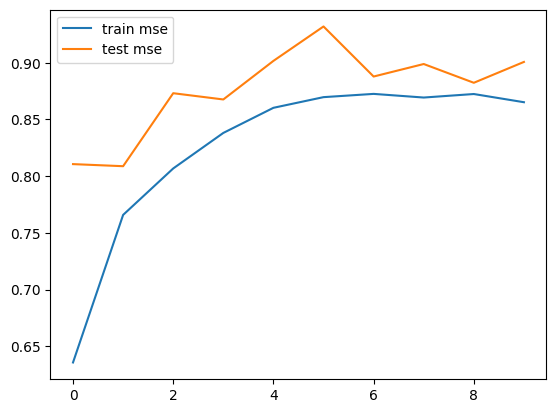

In [ ]:
# Plot losses
plt.plot(history_VGG16.history['loss'], label="train loss")
plt.plot(history_VGG16.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# Plot MSE
plt.plot(history_VGG16.history['accuracy'], label="train mse")
plt.plot(history_VGG16.history[ 'val_accuracy'], label="test mse")
plt.legend()
plt.show()

In [ ]:
score_VGG16 = model_VGG16.evaluate_generator(test_generator)
print('Test loss:', score_VGG16[0])
print('Test accuracy:', score_VGG16[1])

Test loss: 0.30993133783340454
Test accuracy: 0.9076782464981079


In [ ]:
#from tensorflow.keras.models import load_model
#best_model = load_model('VGG16_model.h5')

In [ ]:
#score = best_model.evaluate_generator(test_generator)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

Test loss: 0.30993136763572693
Test accuracy: 0.9076782464981079


# VGG19

In [ ]:
from tensorflow.keras.applications import VGG19

def build_model_VGG19(name, weights_path=None):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(4096, activation='leaky_relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(1024, activation='sigmoid')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    predictions = Dense(20, activation='softmax')(x)

    model = Model(name=name, inputs=base_model.input, outputs=predictions)
    if weights_path:
        model.load_weights(weights_path)
    return model

In [ ]:
NAME = "InceptionV3-{}".format(int(time.time()))
model_VGG19 = build_model_VGG19(NAME)
model_VGG19.summary()

80134624/80134624 [==============================] - 4s 0us/step
Model: "InceptionV3-1702405076"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                             

In [ ]:
model_VGG19.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr),
              metrics=['accuracy'])

In [ ]:
history_VGG19 = model_VGG19.fit_generator(train_generator,
                    validation_data = valid_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    epochs=epochs,
                    )

Epoch 1/10
273/273 [==============================] - 227s 824ms/step - loss: 1.8359 - accuracy: 0.6357 - val_loss: 1.4535 - val_accuracy: 0.6360
Epoch 2/10
273/273 [==============================] - 220s 805ms/step - loss: 1.0075 - accuracy: 0.7549 - val_loss: 0.3989 - val_accuracy: 0.8621
Epoch 3/10
273/273 [==============================] - 222s 812ms/step - loss: 0.6911 - accuracy: 0.8071 - val_loss: 0.4368 - val_accuracy: 0.8631
Epoch 4/10
273/273 [==============================] - 219s 802ms/step - loss: 0.5652 - accuracy: 0.8300 - val_loss: 0.3369 - val_accuracy: 0.8704
Epoch 5/10
273/273 [==============================] - 219s 803ms/step - loss: 0.4817 - accuracy: 0.8474 - val_loss: 0.3625 - val_accuracy: 0.8667
Epoch 6/10
273/273 [==============================] - 217s 793ms/step - loss: 0.4461 - accuracy: 0.8535 - val_loss: 0.3296 - val_accuracy: 0.8943
Epoch 7/10
273/273 [==============================] - 217s 793ms/step - loss: 0.4307 - accuracy: 0.8581 - val_loss: 0.2742 -

In [ ]:
model_VGG19.save('VGG19_model.h5')

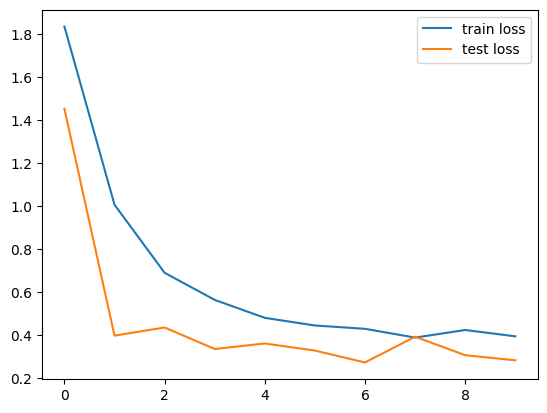

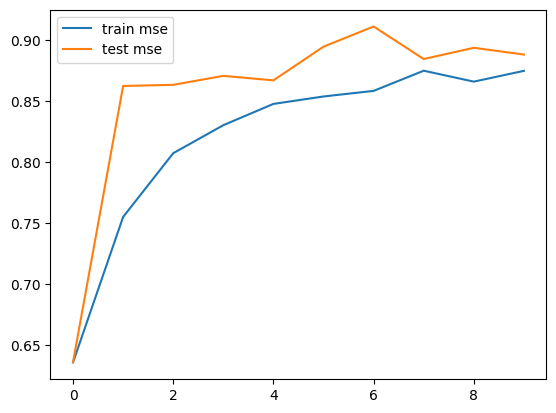

In [ ]:
# Plot losses
plt.plot(history_VGG19.history['loss'], label="train loss")
plt.plot(history_VGG19.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# Plot MSE
plt.plot(history_VGG19.history['accuracy'], label="train mse")
plt.plot(history_VGG19.history[ 'val_accuracy'], label="test mse")
plt.legend()
plt.show()

In [ ]:
score_VGG19 = model_VGG19.evaluate_generator(test_generator)
print('Test loss:', score_VGG19[0])
print('Test accuracy:', score_VGG19[1])

Test loss: 0.37200191617012024
Test accuracy: 0.8957952260971069


# Inception 299X299

In [ ]:
def build_model_Inception(name, weights_path=None):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(4096, activation='leaky_relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(1024, activation='sigmoid')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    predictions = Dense(20, activation='softmax')(x)

    model = Model(name=name, inputs=base_model.input, outputs=predictions)
    if weights_path:
        model.load_weights(weights_path)
    return model


In [ ]:
NAME = "InceptionV3-{}".format(int(time.time()))
model_InceptionV3 = build_model_Inception(NAME)
model_InceptionV3.summary()

Model: "InceptionV3-1702407446"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 

In [ ]:
model_InceptionV3.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr),
              metrics=['accuracy'])

In [ ]:
history_InceptionV3 = model_InceptionV3.fit_generator(train_generator,
                    validation_data = valid_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    epochs=epochs,
                    )

Epoch 1/10
273/273 [==============================] - 217s 786ms/step - loss: 1.9094 - accuracy: 0.6064 - val_loss: 1.0528 - val_accuracy: 0.7353
Epoch 2/10
273/273 [==============================] - 213s 781ms/step - loss: 1.0542 - accuracy: 0.7472 - val_loss: 0.4981 - val_accuracy: 0.8483
Epoch 3/10
273/273 [==============================] - 216s 791ms/step - loss: 0.7437 - accuracy: 0.7987 - val_loss: 0.4834 - val_accuracy: 0.8364
Epoch 4/10
273/273 [==============================] - 215s 787ms/step - loss: 0.5474 - accuracy: 0.8277 - val_loss: 0.3042 - val_accuracy: 0.8814
Epoch 5/10
273/273 [==============================] - 215s 788ms/step - loss: 0.4599 - accuracy: 0.8515 - val_loss: 0.2822 - val_accuracy: 0.9053
Epoch 6/10
273/273 [==============================] - 216s 790ms/step - loss: 0.4128 - accuracy: 0.8625 - val_loss: 0.2629 - val_accuracy: 0.9099
Epoch 7/10
273/273 [==============================] - 216s 789ms/step - loss: 0.4108 - accuracy: 0.8657 - val_loss: 0.4254 -

In [ ]:
model_InceptionV3.save('Inceptionv3_model.h5')

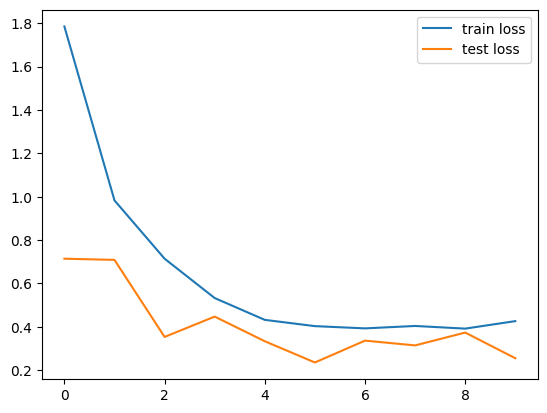

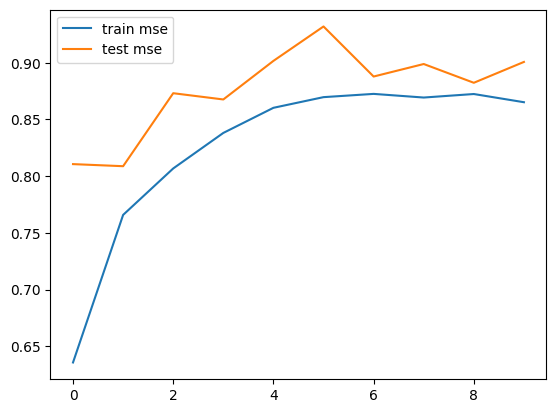

In [ ]:
# Plot losses
plt.plot(history_InceptionV3.history['loss'], label="train loss")
plt.plot(history_InceptionV3.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# Plot MSE
plt.plot(history_InceptionV3.history['accuracy'], label="train mse")
plt.plot(history_InceptionV3.history[ 'val_accuracy'], label="test mse")
plt.legend()
plt.show()

In [ ]:
score_InceptioV3 = model_InceptionV3.evaluate_generator(test_generator)
print('Test loss:', score_InceptioV3[0])
print('Test accuracy:', score_InceptioV3[1])

Test loss: 0.3731272220611572
Test accuracy: 0.8884826302528381


# ResNet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.applications import ResNet50

def build_model_ResNet50(name, weights_path=None):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    predictions = Dense(20, activation='softmax')(x)

    model = Model(name=name, inputs=base_model.input, outputs=predictions)
    if weights_path:
        model.load_weights(weights_path)
    return model


In [ ]:
import time
NAME = "ResNet50-{}".format(int(time.time()))
model_ResNet50 = build_model_ResNet50(NAME)
model_ResNet50.summary()


Model: "ResNet50-1702465413"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                            

In [ ]:
lr = 0.01
epochs = 10

model_ResNet50.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr),
              metrics=['accuracy'])


In [ ]:
history_ResNet50 = model_ResNet50.fit_generator(train_generator,
                    validation_data = valid_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    epochs=epochs,
                    )

Epoch 1/10
273/273 [==============================] - 313s 1s/step - loss: 3.0217 - accuracy: 0.3628 - val_loss: 2.2753 - val_accuracy: 0.3980
Epoch 2/10
273/273 [==============================] - 260s 950ms/step - loss: 1.8363 - accuracy: 0.4821 - val_loss: 1.4531 - val_accuracy: 0.5193
Epoch 3/10
273/273 [==============================] - 260s 950ms/step - loss: 1.3367 - accuracy: 0.5711 - val_loss: 1.1601 - val_accuracy: 0.6232
Epoch 4/10
273/273 [==============================] - 258s 946ms/step - loss: 1.1601 - accuracy: 0.6155 - val_loss: 1.1938 - val_accuracy: 0.6195
Epoch 5/10
273/273 [==============================] - 267s 978ms/step - loss: 1.1136 - accuracy: 0.6304 - val_loss: 1.2044 - val_accuracy: 0.6204
Epoch 6/10
273/273 [==============================] - 256s 937ms/step - loss: 1.0516 - accuracy: 0.6593 - val_loss: 0.9369 - val_accuracy: 0.7004
Epoch 7/10
273/273 [==============================] - 261s 955ms/step - loss: 1.0422 - accuracy: 0.6636 - val_loss: 0.8902 - va

In [ ]:
model_ResNet50.save('ResNet50_model.h5')


In [ ]:
#model_ResNet50.save('/content/drive/MyDrive/Your/Model/Path/model_ResNet50.h5')


In [ ]:
# Plot losses
plt.plot(model_ResNet50.history['loss'], label="train loss")
plt.plot(model_ResNet50.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# Plot MSE
plt.plot(model_ResNet50.history['accuracy'], label="train mse")
plt.plot(model_ResNet50.history[ 'val_accuracy'], label="test mse")
plt.legend()
plt.show()

In [ ]:
score_ResNet50 = model_ResNet50.evaluate_generator(test_generator)
print('Test loss:', score_ResNet50[0])
print('Test accuracy:', score_ResNet50[1])

Test loss: 1.0283277034759521
Test accuracy: 0.702010989189148


# Recomendations :

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import os

# Load the trained VGG16 model
model_ResNet50_load = load_model('ResNet50_model.h5')


In [ ]:

# Function to recommend similar items for a test image
def recommend_similar_items(model, test_image_path, train_embeddings, train_image_paths, k=5):
    # Preprocess the test image
    img = image.load_img(test_image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Get the embeddings for the test image
    test_embedding = model.predict(img_array)

    # Calculate similarity between the test image and training images
    similarities = cosine_similarity(test_embedding, train_embeddings)

    # Get indices of items sorted by similarity (descending order)
    ranked_indices = np.argsort(similarities[0])[::-1]

    # Retrieve top-K recommendations
    top_k_recommendations = train_image_paths[ranked_indices[:k]]

    return top_k_recommendations


In [ ]:
# Extract embeddings from the trained model for all training images
train_embeddings = []
train_image_paths = []

for img_path in train_generator.filepaths:
    print(img_path)
    img_embedding = model_ResNet50_load.predict(img_path)
    train_embeddings.append(img_embedding.flatten())
    train_image_paths.append(img_path)

train_embeddings = np.array(train_embeddings)

./fashion-dataset/fashion-dataset/images/58959.jpg


IndexError: ignored

In [ ]:
## Assuming you have a DataFrameIterator called 'test_generator'
first_batch = next(test_generator)

# Display the first batch
#print(first_batch)
features = first_batch[0]  # Assuming features are in the first position of the tuple
#print(features)
target_features = features
target_features = model_VGG16.predict(target_features)


1/1 [==============================] - 2s 2s/step


In [ ]:

# #Load and preprocess the target image
#target_image_path = test_df.at[0, 'filename']
#img = image.load_img(target_image_path, target_size=(224, 224))
#img_array = image.img_to_array(img)
#img_array = np.expand_dims(img_array, axis=0)
#img_array = preprocess_input(img_array)

## Get the features of the target image
#target_features = model_VGG16.predict(img_array)


1/1 [==============================] - 1s 1s/step


In [ ]:
target_features = model_VGG16.predict(test_generator_image)

In [ ]:
target_features

In [ ]:
# Calculate the similarity between the target image and all other images in the dataset
def calculate_similarity(features1, features2):
    return np.dot(features1, features2) / (np.linalg.norm(features1) * np.linalg.norm(features2))


# Assuming you have a DataFrame called 'data' with a column 'filename' containing image paths
data['similarity_score'] = data['filename'].apply(
    lambda x: calculate_similarity(target_features.flatten(), train_generator))


In [ ]:

# Sort the DataFrame based on similarity scores
recommended_images = data.sort_values(by='similarity_score', ascending=False)['filename'].tolist()

# Display or use the recommended images
print("Recommended images:")
for i, img_path in enumerate(recommended_images[:10]):  # Adjust the number of recommendations as needed
    print(f"{i + 1}. {img_path}")